<a href="https://colab.research.google.com/github/KotkaZ/journey-to-zero/blob/master/lstm-long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset preprocessing



In [1]:
import numpy as nb
import pandas as pd

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

%matplotlib inline

import datetime

### Timestamp extraction

Because crazy things happened in the past year,  we validated that, some specific dates had significantly higher electricity prices. Therefore we do weekday, month, and time extraction from the timestamp.  



### Feature dropping

In Estonia, there are approximately 500\-800 millimeters of rain on average. Our dataset consisted of only about 140mm of rain, which is definitely not correct. Also, the amount of snow was inappropriate for the  
 same reason.


In [2]:
def drop_features(dataset):
    dataset.drop(columns=['snow','prcp'], inplace=True)


In [3]:
def drop_rows(dataset):
    # Deal with NaN values
    initial_len = len(dataset)
    display(dataset.head())
    dataset.dropna(inplace=True)
    new_len = len(dataset)
    if (initial_len != new_len):
        print(f'Dropped {initial_len - new_len} row')

    # Deal with outliners
    dataset.drop(dataset[dataset['el_price'] > 1].index , inplace=True)

In [4]:
def normalize(dataset, scaler = None) -> (pd.DataFrame, preprocessing.MinMaxScaler):
    if scaler:
        dataset_scaled = scaler.transform(dataset)
        return (dataset_scaled, scaler)
    scaler = preprocessing.MinMaxScaler()
    dataset_scaled = scaler.fit_transform(dataset)
    return (dataset_scaled, scaler)

In [5]:
def reduce_dimensions(dataset, pca = None) -> (pd.DataFrame, decomposition.PCA):
    if pca:
        dataset_reduced = pca.transform(dataset)
        return (dataset_reduced, pca)
    pca = decomposition.PCA(n_components=0.9)
    dataset_reduced = pca.fit_transform(dataset)
    return (dataset_reduced, pca)

In [6]:
def preprocess(dataset, encoder=None):
    drop_features(dataset)
    drop_rows(dataset)


### Import dataset

Here we import dataset, do inital processing and split into train and validation.

In [7]:
def read_dataset(file_name) -> pd.DataFrame:
    return pd.read_csv(file_name).set_index('time').sort_index()

In [8]:
def extract_labels(dataset) -> (pd.DataFrame, pd.Series):
    X_train = dataset.loc[:, ~dataset.columns.isin(['consumption'])]
    y_train = dataset['consumption']
    return (X_train, y_train)

In [9]:
train_df = read_dataset('train.csv')
preprocess(train_df)

X_train, y_train = extract_labels(train_df)

X_train_norm, scaler_data = normalize(X_train)


,temp,dwpt,rhum,wdir,wspd,wpgt,pres,coco,el_price,consumption
time,,,,,,,,,,
2021-09-01 00:00:00+03:00,11.2,10.3,94.0,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
2021-09-01 01:00:00+03:00,10.7,9.6,93.0,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2021-09-01 02:00:00+03:00,9.9,9.0,94.0,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
2021-09-01 03:00:00+03:00,10.0,8.4,90.0,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
2021-09-01 04:00:00+03:00,9.0,8.1,94.0,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


Dropped 198 row


In [10]:
X_test = read_dataset('test.csv')
preprocess(X_test)

X_test_norm, _ = normalize(X_test, scaler_data)

,temp,dwpt,rhum,wdir,wspd,wpgt,pres,coco,el_price
time,,,,,,,,,
2022-08-25 00:00:00+03:00,21.1,15.2,69.0,340.0,9.0,9.3,1022.0,2.0,0.25533
2022-08-25 01:00:00+03:00,20.1,15.1,73.0,30.0,6.0,14.8,1022.0,2.0,0.19492
2022-08-25 02:00:00+03:00,20.1,15.1,73.0,320.0,7.0,13.0,1022.0,2.0,0.18853
2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,4.0,11.1,1022.4,4.0,0.19947
2022-08-25 04:00:00+03:00,18.1,17.1,94.0,280.0,7.0,11.1,1022.0,3.0,0.21192


In [12]:
from sklearn.model_selection import train_test_split

#X_train = X_train_norm
#y_train = y_train
X_train, X_val,  y_train, y_val = train_test_split(X_train_norm, y_train, test_size=0.05)

In [13]:
X_train[0]

array([0.87826087, 0.85282258, 0.3875    , 0.52777778, 0.22712934,
       0.41430948, 0.51590106, 0.04166667, 0.36850887])

In [14]:
import itertools

# Numpy
import numpy as np

# Keras
from keras.layers import Dense, Input, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD

# Pandas
import pandas as pd

# Sklearn
import sklearn.preprocessing
import sklearn.utils

# Visualiseerimine
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
X_train.shape[1]

9

In [16]:
X_train = np.expand_dims(X_train, axis=-1)
#X_val = np.expand_dims(X_val, axis=-1)

X_train.shape

(6713, 9, 1)

In [19]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, LSTM, SimpleRNN, Embedding, GRU

mdl = Sequential()

mdl.add(LSTM(4,  input_shape=(X_train.shape[1], X_train.shape[2])))
mdl.add(Dense(1))

mdl.compile(loss='mae', optimizer="adam")


In [20]:
history = mdl.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100, batch_size=1, verbose=True)
#history = mdl.fit(X_train, y_train, epochs=15, batch_size=32, verbose=True)

Epoch 1/100
6713/6713 [==============================] - 28s 4ms/step - loss: 0.6469 - val_loss: 0.6457
Epoch 2/100
6713/6713 [==============================] - 24s 4ms/step - loss: 0.6402 - val_loss: 0.6473
Epoch 3/100
6713/6713 [==============================] - 23s 3ms/step - loss: 0.6350 - val_loss: 0.6354
Epoch 4/100
6713/6713 [==============================] - 26s 4ms/step - loss: 0.6254 - val_loss: 0.6191
Epoch 5/100
6713/6713 [==============================] - 25s 4ms/step - loss: 0.6141 - val_loss: 0.6112
Epoch 6/100
6713/6713 [==============================] - 26s 4ms/step - loss: 0.6021 - val_loss: 0.6052
Epoch 7/100
6713/6713 [==============================] - 23s 3ms/step - loss: 0.5950 - val_loss: 0.6112
Epoch 8/100
6713/6713 [==============================] - 26s 4ms/step - loss: 0.5896 - val_loss: 0.6005
Epoch 9/100
6713/6713 [==============================] - 24s 4ms/step - loss: 0.5861 - val_loss: 0.5945
Epoch 10/100
6713/6713 [==============================] - 23s 3m

Text(0.5, 1.0, 'Loss')

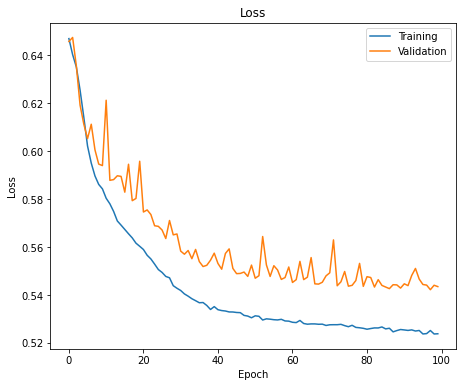

In [21]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

#plt.subplot(1, 2, 2)
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend(['Training', 'Validation'])
#plt.title('Accuracy')

In [22]:
prediction = mdl.predict(X_test_norm, batch_size=1)

168/168 [==============================] - 1s 2ms/step


In [23]:
prediction

array([[0.5385392 ],
       [0.4231603 ],
       [0.4673668 ],
       [0.37928045],
       [0.37270612],
       [0.37154847],
       [0.37035322],
       [0.5565208 ],
       [0.6515976 ],
       [0.5275879 ],
       [0.5447475 ],
       [0.56960154],
       [0.5703037 ],
       [0.5802058 ],
       [0.61777496],
       [0.59440315],
       [0.6132308 ],
       [0.6699966 ],
       [0.61072147],
       [0.5584949 ],
       [0.5321113 ],
       [0.5445453 ],
       [0.3770535 ],
       [0.33886093],
       [0.28669298],
       [0.2815115 ],
       [0.27803785],
       [0.29282224],
       [0.325247  ],
       [0.33194256],
       [0.32904595],
       [0.3632689 ],
       [0.41077447],
       [0.4699067 ],
       [0.4917612 ],
       [0.55313766],
       [0.58753633],
       [0.58138144],
       [0.5931817 ],
       [0.5981771 ],
       [0.63340676],
       [0.61803675],
       [0.63242257],
       [0.6192658 ],
       [0.49752915],
       [0.5080148 ],
       [0.34614915],
       [0.297

In [24]:
X_test = read_dataset('test.csv')

In [25]:
predictions_dict = {'time':X_test.index,'consumption':[el[0]for el in prediction]}
pred_df = pd.DataFrame(predictions_dict)
pred_df.to_csv('submission_081222_v4.csv',index=False)